# Image Analysis with Python - <font color='green'>Tutorial Pipeline Section 1</font>

*originally created by Jonas Hartmann (Gilmour group, EMBL Heidelberg) in 2018*<br>
*updated and modified in 2022 by Cheng-Yu Huang*<br>

##  Table of Contents

1. [About this Tutorial](#about)
2. [Importing Modules & Packages](#import)
3. [Loading & Handling Image Data](#load)
4. [Preprocessing](#prepro)
5. [Manual Thresholding & Threshold Detection](#thresh)
6. [Adaptive Thresholding](#adaptive)
7. [Improving Masks with Binary Morphology](#morpho)
8. [Connected Components Labeling](#label)
9. [Cell Segmentation by Seeding & Expansion](#seg)

##  About this Tutorial <a id=about></a>

*This tutorial aims to teach the basics of (bio-)image processing with python, in particular the analysis of fluorescence microscopy data. The tutorial is self-explanatory and follows a "learning by doing" philosophy. It consists of step by step instructions that guide students through the construction of a 2D single-cell segmentation pipeline.*

#### Background 

The aim is to construct a pipeline for the identification and segmentation of cells in 2D confocal fluorescence microscopy images of a tissue with labeled membranes. This is among the most common tasks in bio-image analysis and is often essential for the extraction of useful quantitative information from microscopy data.

The pipeline is constructed based on provided example images (see `example_data` directory), which are single-color spinning-disk confocal micrographs (objective: `40X 1.2NA W`) of cells in live zebrafish embryos in early development (~10h post fertilization), fluorescently labeled with a membrane-localized fusion protein (`mNeonGreen:Ggamma9`).

*Everything ready? Yes? Then let's get started!*

----

## Importing Modules & Packages <a id=import></a>

Let's start by importing the package NumPy, which enables the manipulation of numerical arrays:

In [1]:
import numpy as np

*<font color=red>Important note:</font> If you are not at all familiar with ```import```, arrays and NumPy, we strongly recommend that you first complete an introductory tutorial on this topic before carrying on!*

Recall that, once imported, we can use functions/modules from the package, for example to create an array:

In [2]:
a = np.array([1, 2, 3])

print(a)
print(type(a))

[1 2 3]
<class 'numpy.ndarray'>


#### <font color='teal'>Exercise</font>

Using the import command as above, import two additional modules that we will be using frequently in this pipeline:

In [3]:
# The image processing module scipy.ndimage as ndi
### YOUR CODE HERE!
import scipy.ndimage as ndi

## Loading & Handling Image Data <a id=load></a>

#### <font color='teal'>Exercise</font>

We will now proceed to load one of the example images and verify that we get what we expect. Follow the instructions in the comments below.

In [4]:
# (i) Specify the file path
# Create a string variable "filepath" with the path to the file you'd like to load (here: 'example_data\example_cells_1.tif').
### YOUR CODE HERE!
filepath = r'example_data\Leaf_PM_Nuclei.tif' # This is a relative path

# Note: Paths and filenames can contain slashes, empty spaces and other special symbols, which can cause 
#       trouble for programming languages under certain circumstances. To circumvent such trouble, add 
#       the letter r before your string definition to create a so-called 'raw string', which is not
#       affected by these problems (e.g. my_raw_string = r"some string with funny symbols: \\\!/~***!").

In [5]:
# (ii) Load the image

# Import the function 'imread' from the module 'skimage.io'.
### YOUR CODE HERE!
from skimage.io import imread

# Load 'example_cells_1.tif' and store it in a variable.
# Suggested name for the variable: img
### YOUR CODE HERE!
img = imread(filepath)

In [6]:
# (iii) Check variable type, file shape and data type

# Print that 'img' is a variable of type 'ndarray' - use Python's built-in function 'type'.
### YOUR CODE HERE!
print("Loaded array is of type:", type(img))

# Print the shape of the array by looking at its 'shape' attribute. 
# Make sure you understand the output!
### YOUR CODE HERE!
print("Loaded array has shape:", img.shape)

# Print the datatype of the individual numbers in the array. You can use the array attribute 'dtype' to do so.
# Make sure you understand the output!
### YOUR CODE HERE!
print("Loaded values are of type:", img.dtype)

Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (2, 2362, 1892)
Loaded values are of type: uint8


Note: The dtype should be 'uint8', because these are unsigned 8-bit integer images.

This means that the intensity values range from 0 to 255 in steps of 1.

Notice that the shape of the image, as indicated by ```img.shape```, says that the size of the first dimension is two. It means that this image has two channels.

Here we will split channel, to process two channels separately

In [56]:
# (iv) Split channel, and save the splitted images as variable 'img_ch0' and 'img_ch1'

img_ch0 = img[0,480:1040,480:1040]
img_ch1 = img[1,480:1040,480:1040]

img_ch0 = img[0,:,:]
img_ch1 = img[1,:,:]

Text(0.5, 1.0, 'Channel 1')

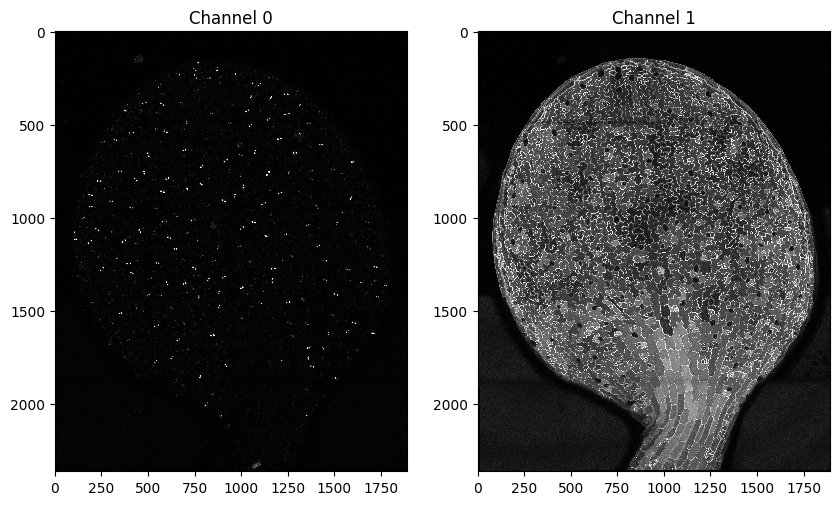

In [57]:
# (iv) Image visulization with matplotlib
# This is the most classic/ original way in python to show image

# First import plotting module matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Use plt.imshow to display the image. plt.imshow has parameters that can be specified, such as:
#  * colormap (cmap): for common bioimage analysis purpose you will set it to 'gray'. There are other options, such as 'viridis' and 'autumn' or 'winter'
#  * interpolation: for scientific purpose we don't want any interpolation, so set it to 'none'. The default setting is 'antialiased'
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img_ch0, interpolation='none', cmap='gray')
ax[1].imshow(img_ch1, interpolation='none', cmap='gray')
ax[0].set_title('Channel 0')
ax[1].set_title('Channel 1')

# P.S. You can have plt.figure() before plt.imshow() to define the figure size. For example:
# plt.figure(figsize=(7,7))
# plt.imshow(img, interpolation='none', cmap='gray')

In [58]:
# (v) Image visulization with napari: 
# This is the relatively new way in python to show image. In this workshop we will use napari for visulization

# First import module napari
import napari

# Create an empty viewer object
viewer = napari.Viewer()

# Use viewer.add_image() and pass the image as a variable to visulize the image. Similar to that for matplotlib, set options:
#  * colormap as 'gray'
#  * interpolation (interpolation2d) is 'nearest' (which correspond to minimum interpolation) by default, so no need to specify 
#  * name as 'Raw Image'
viewer.add_image(img_ch0, colormap = 'green', name= 'Raw Image', blending= 'additive')
viewer.add_image(img_ch1, colormap = 'red', name= 'Raw Image', blending= 'additive')

# Don't close the Napari window - from now on we will add our intermediate results to the napari window

<Image layer 'Raw Image [1]' at 0x158c7a2aaf0>

In this notebook we are only interested in channel 1, which gives information about the cell wall

## Preprocessing <a id=prepro></a>

#### Background

The goal of image preprocessing is to prepare or optimize the images to make further analysis easier. Usually, this boils down to increasing the signal-to-noise ratio by removing noise and background and by enhancing structures of interest. The specific preprocessing steps used in a pipeline depend on the type of sample, the microscopy technique used, the image quality, and the desired downstream analysis. 

#### Gaussian Smoothing

A Gaussian filter smoothens an image by convolving it with a Gaussian-shaped kernel. In the case of a 2D image, the Gaussian kernel is also 2D and will look something like this:

<img src="ipynb_images\gaussian_kernel_grid.png" alt="Gaussian Kernel Figure" style="width: 150px;"/>

How much the image is smoothed by a Gaussian kernel is determined by the standard deviation  of the Gaussian distribution, usually referred to as **sigma** ($\sigma$). A higher $\sigma$ means a broader distribution and thus more smoothing.

**How to choose the correct value of $\sigma$?**

This depends a lot on your images, in particular on the pixel size. In general, the chosen $\sigma$ should be large enough to blur out noise but small enough so the "structures of interest" do not get blurred too much. Usually, the best value for $\sigma$ is simply found by trying out some different options and looking at the result. 

#### <font color='teal'>Exercise</font>

Perform Gaussian smoothing and visualize the result.

Follow the instructions in the comments below.

In [59]:
# (i) Import the image processing module scipy.ndimage as ndi

import scipy.ndimage as ndi

In [60]:
# (ii) Create a variable for the smoothing factor sigma, which should be an integer value

sigma = 2
# After implementing the Gaussian smoothing function below, you can modify this variable 
# to find the ideal value of sigma.

In [61]:
# (iii) Perform the smoothing on the image

# To do so, use the Gaussian filter function 'ndi.gaussian_filter' from the 
# image processing module 'scipy.ndimage'. Check out the documentation of scipy to see how to use this function. 
# Allocate the output to a new variable 'img_smooth'
img_smooth = ndi.gaussian_filter(img_ch1, sigma)

In [62]:
# (iv) Visualize the result using Napari
# Hint: refer to the part (v) of the last section, except that now you don't have the initiate the viewer object.
viewer.add_image(img_smooth, colormap = 'gray', name= f'Gaussian Smoothed Image (sigma = {sigma})')

<Image layer 'Gaussian Smoothed Image (sigma = 2)' at 0x158c9354100>

## Manual Thresholding & Threshold Detection <a id=thresh></a>

#### Background

The easiest way to distinguish foreground objects (here: membranes) from the image background is to threshold the image, meaning all pixels with an intensity above a certain threshold are accepted as foreground, all others are set as background.

To find the best threshold for a given image, one option is to simply try out different thresholds manually. Alternatively, one of many algorithms for automated **'threshold detection'** can be used. These algorithms use information about the image (such as the histogram) to automatically find a suitable threshold value, often under the assumption that the background and foreground pixels in an image belong to two clearly distinct populations in terms of their intensity. 

There are many different algorithms for threshold detection and it is often hard to predict which one will produce the nicest and most robust result for a particular dataset. It therefore makes sense to try out a bunch of different options.

For this pipeline, we will ultimately use a more advanced thresholding approach, which also accounts (to some extent) for variations in signal across the field of view: adaptive thresholding. 

But first, let's experiment a bit with threshold detection.

#### <font color='teal'>Exercise</font>

Try out manual thresholding and automated threshold detection.

Follow the instructions in the comments below.

In [75]:
# (i) Create a variable for a manually set threshold, which should be an integer

# This can be changed later to find a suitable value.
thresh = 30

In [76]:
# (ii) Perform thresholding on the smoothed image

# Remember that you can use relational (Boolean) expressions such as 'smaller' (<), 'equal' (==)
# or 'greater or equal' (>=) with numpy arrays - and you can directly assign the result to a new
# variable.
mem = img_smooth > thresh

# Check the dtype of your thresholded image
# You should see that the dtype is 'np.bool', which stands for 'Boolean' and means the array
# is now simply filled with 'True' and 'False', where 'True' is the foreground (the regions
# above the threshold) and 'False' is the background.
print(mem.dtype)

bool


In [77]:
# (iii) Visualize the result

viewer.add_image(mem, colormap = 'gray', name= f'Thresholded Image (sigma = {thresh})')

<Image layer 'Thresholded Image (sigma = 30)' at 0x158ef049610>

In [72]:
# (iv) Try out different thresholds to find the best one

# If you are using jupyter notebook, you can adapt the code below to
# interactively change the threshold and look for the best one. These
# kinds of interactive functions are called 'widgets' and are very 
# useful in exploratory data analysis to create greatly simplified
# 'User Interfaces' (UIs) on the fly.
# As a BONUS exercise, try to understand or look up how the widget works
# and play around with it a bit!
# (Note: If this just displays a static image without a slider to adjust
#        the threshold or if it displays a text warning about activating
#        the 'widgetsnbextension', check out the note below!)

# Prepare widget
from ipywidgets import interact
@interact(thresh=(10,250,10))
def select_threshold(thresh=100):
    
    # Thresholding
    ### ADAPT THIS: Change 'img_smooth' into the variable you stored the smoothed image in!
    mem = img_smooth > thresh
    
    # Visualization
    plt.figure(figsize=(7,7))
    plt.imshow(mem, interpolation='none', cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=100, description='thresh', max=250, min=10, step=10), Output()), _dom_cl…

In [73]:
# (v) Perfom automated threshold detection with Otsu's method

# The scikit-image module 'skimage.filters.thresholding' provides
# several threshold detection algorithms. The most popular one 
# among them is Otsu's method. Using what you've learned so far,
# import the 'threshold_otsu' function, use it to automatically 
# determine a threshold for the smoothed image, apply the threshold,
# and visualize the result.
### YOUR CODE HERE!
# Import
from skimage.filters.thresholding import threshold_otsu

# Calculate and apply threshold
thresh = threshold_otsu(img_smooth)
mem = img_smooth > thresh
    
# Visualization
viewer.add_image(mem, colormap = 'gray', name= f'Otsu\'s Thresholded Image')

<Image layer "Otsu's Thresholded Image" at 0x158e0c776a0>

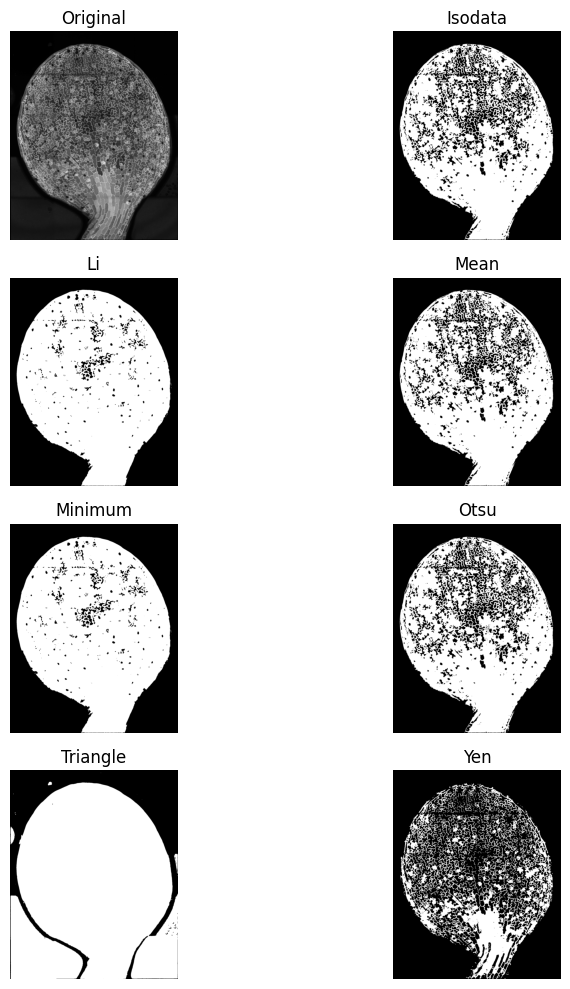

In [74]:
# (vi) BONUS: Did you notice the 'try_all_threshold' function?

# That's convenient! Use it to automatically test the threshold detection
# functions in 'skimage.filters.thresholding'. Don't forget to adjust the
# 'figsize' parameter so the resulting images are clearly visible.
### YOUR CODE HERE!
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(img_smooth, figsize=(10,10), verbose=False)

## Adaptive Thresholding <a id=adaptive></a>

#### Background

Simply applying a fixed intensity threshold does not always produce a foreground mask of sufficiently high quality, since background and foreground intensities often vary across the image. In our example image, for instance, the intensity drops at the image boundaries - a problem that cannot be resolved just by changing the threshold value.

One way of addressing this issue is to use an *adaptive thresholding* algorithm, which adjusts the threshold locally in different regions of the image to account for varying intensities.

Although `scikit-image` provides a function for adaptive thresholding (called `threshold_local`), we will here implement our own version, which is slightly different and will hopefully make the concept of adaptive thresholding very clear.

Our approach to adaptive tresholding works in two steps:

1. Generation of a "background image"

 This image should - across the entire image - always have higher intensities than the local background but lower intensities than the local foreground. This can be achieved by strong blurring/smoothing of the image, as illustrated in this 1D example:

 <img src="ipynb_images\adaptive_bg_1D.png" alt="Adaptive Background Figure" style="width: 400px;"/><br>
    
2. Thresholding of the original image with the background

 Instead of thresholding with a single value, every pixel in the image is thresholded with the corresponding pixel of the "background image".

#### <font color='teal'> Exercise </font>

Implement the two steps of the adaptive background subtraction:

1. Use a strong "mean filter" (aka "uniform filter") to create the background image. This simply assigns each pixel the average value of its local neighborhood. Just like the Gaussian blur, this can be done by convolution, but this time using a "uniform kernel" like this one:

 <img src="ipynb_images\uniform_filter_SE.png" alt="Uniform Filter SE Figure" style="width: 300px;"/>
    
 To define which pixels should be considered as the local neighborhood of a given pixel, a `structuring element` (`SE`) is    used. This is a small binary image where all pixels set to `1` will be considered as part of the neighborhood and all pixels set to `0` will not be considered. Here, we use a disc-shaped `SE`, as this reduces artifacts compared to a square `SE`.
  
 *Side note:* A strong Gaussian blur would also work to create the background mask. For the Gaussian blur, the analogy to the `SE` is the `sigma` value, which in a way also determines the size of the local neighborhood.<br><br>

2. Use the background image for thresholding. In practical terms, this works in exactly the same way as thresholding with a single value, since numpy arrays will automatically perform element-wise (pixel-by-pixel) comparisons when compared to other arrays of the same shape by a relational (Boolean) expression.

Follow the instructions in the comments below.

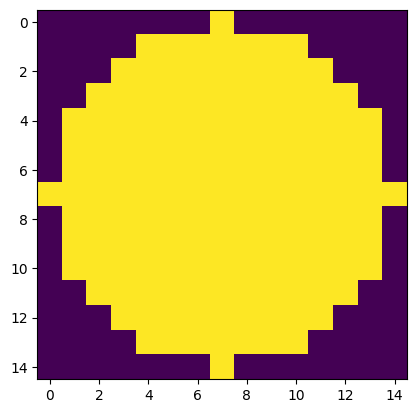

In [63]:
# Step 1
# ------

# (i) Create a disk-shaped structuring element (SE) and asign it to a new variable.

# Import module disk from skimage.morphology
from skimage.morphology import disk

# Create SE for mean filtering
# Set radius r for the disk
r = 7
# create disk, save it as SE
SE = disk(r)

# Visualize the SE
plt.imshow(SE, interpolation='none')

In [64]:
# (ii) Create the background, and visulize

# Run a mean filter over the image using the disc SE and assign the output to a new variable.
# Use the function 'skimage.filters.rank.mean'.
from skimage.filters import rank 

background = rank.mean(img_smooth, footprint=SE)

viewer.add_image(background, colormap = 'gray', name= f'Background')

<Image layer 'Background' at 0x158c94f4f40>

In [65]:
# Step 2
# ------

# (iii) Threshold the Gaussian-smoothed original image (img_smooth) against the background image created in step 1 
#      using a relational expression

mem = img_smooth > background

In [67]:
# (v) Visualize and understand the output. 

viewer.add_image(mem, colormap = 'gray', name= f'Adaptive Filtered')

# What do you observe? 
# Are you happy with this result as a membrane segmentation? 
# Adapt the size of the circular SE to optimize the result!

<Image layer 'Adaptive Filtered [1]' at 0x158cef2e550>

## Improving Masks with Binary Morphology <a id=morpho></a>

#### Background

Morphological operations such as `erosion`, `dilation`, `closing` and `opening` are common tools used to improve masks after they are generated by thresholding. They can be used to fill small holes, remove noise, increase or decrease the size of an object, or smoothen mask outlines.

Most morphological operations are once again simple kernel functions that are applied at each pixel of the image based on their neighborhood as defined by a `structuring element` (`SE`). For example, `dilation` simply assigns to the central pixel the maximum pixel value within the neighborhood; it is a maximum filter. Conversely, `erosion` is a minimum filter. Additional options emerge from combining the two: `morphological closing`, for example, is a `dilation` followed by an `erosion`. This is used to fill in gaps and holes or smoothing mask outlines without significantly changing the mask's area. Finally, there are also some more complicated morphological operations, such as `hole filling`.

#### <font color='teal'>Exercise</font>

Improve the membrane segmentation from above with morphological operations.

Specifically, use `binary hole filling` to get rid of the speckles of foreground pixels that litter the insides of the cells. Furthermore, try different other types of morphological filtering to see how they change the image and to see if you can improve the membrane mask even more, e.g. by filling in gaps.

Follow the instructions in the comments below. Visualize all intermediate results of your work and remember to "zoom in" to get a closer look by slicing out and then plotting a subsection of the image array.

In [38]:
# (i) Get rid of speckles using binary hole filling

# Use the function 'ndi.binary_fill_holes' for this. Be sure to check the docs to
# understand exactly what it does. For this to work as intended, you will have to 
# invert the mask, which you can do using the function `np.logical_not` or the
# corresponding operator '~'. Again, be sure to understand why this has to be done
# and don't forget to revert the result back.

mem_holefilled = ~ndi.binary_fill_holes(~mem)
viewer.add_image(mem_holefilled, colormap = 'gray', name= 'Hole Filled')

<Image layer 'Hole Filled' at 0x158bdc9eac0>

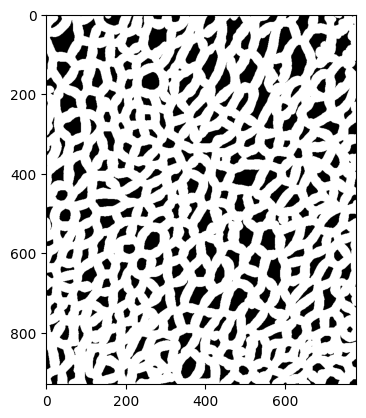

In [24]:
# (ii) Closing the gaps in the membrane by dilation

# Create a SE for the binary operation with disk()
r = 7
SE = disk(r)

# Perform dilation with the python function ndi.binary_dilation
mem_dilated = ndi.binary_dilation(mem_holefilled, structure=SE)

# Now visulize the result
plt.imshow(mem_dilated, cmap = 'gray');

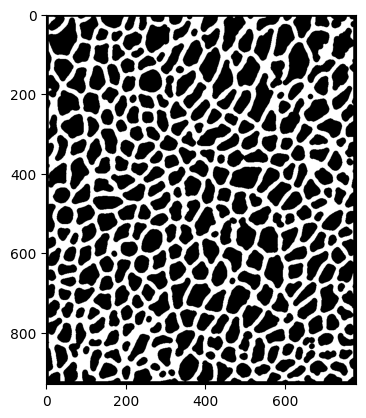

In [25]:
# (iii) Restore the membrane shape by erosion

# Using the same SE as before, perform erosion with ndi.binary_erosion
mem_eroded = ndi.binary_erosion(mem_dilated, structure=SE)

# Now visulize the result
plt.imshow(mem_eroded, cmap = 'gray');

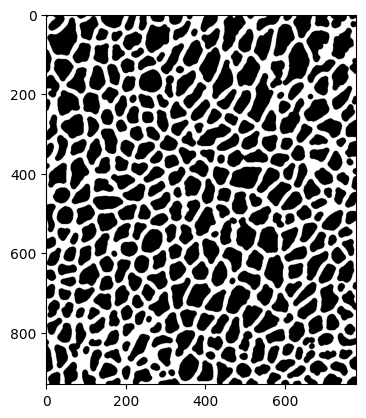

In [26]:
# (iv) [BONUS 1] If you pay close attention, you will notice that some of these operations introduce 
# artefacts at the image boundaries. Can you come up with a way of solving this? (Hint: 'np.pad')
# [BONUS 2] You just did dilation and erosion with the same SE. These two operations
# combined together is called "closing". Try ndi.binary_closing to do the same thing in one line

r = 7
SE = disk(r)
pad_size = r + 1
mem_padded = np.pad(mem_holefilled, pad_size, mode='reflect')
mem_final = ndi.binary_closing(mem_padded, structure=SE)
mem_final = mem_final[pad_size:-pad_size, pad_size:-pad_size]
plt.imshow(mem_final, cmap = 'gray')

In [27]:
# (iii) Visualize the final result

viewer.add_image(mem_final, colormap = 'gray', name= f'Final Membrane Mask')

# At this point you should have a pretty neat membrane mask.
# If you are not satisfied with the quality your membrane segmentation, you should go back 
# and fine-tune the size of the SE in the adaptive thresholding section and also optimize
# the morphological cleaning operations.
# Note that the quality of the membrane segmentation will have a significant impact on the 
# cell segmentation we will perform next.

<Image layer 'Final Membrane Mask' at 0x1c50b119cd0>

## Connected Components Labeling <a id=label></a>

#### Background

Based on the membrane segmentation, we can get a preliminary segmentation of the cells in the image by considering each background region surrounded by membranes as a cell. This can already be good enough for many simple measurements.

The only thing we still need to do in order to get there is to label each cell individually. Only if each separate cell has a unique number (an `ID`) assigned, values such as the mean intensity can be measured and analyzed at the single-cell level.

The approach used to achieve this is called `connected components labeling`. It gives every connected group of foreground pixels a unique `ID` number.

#### <font color='teal'>Exercise</font>

Use your membrane segmentation for connected components labeling.

Follow the instructions in the comments below.

In [28]:
# (i) Label connected components

# Use the function 'ndi.label' from the 'ndimage' module. 
# Note that this function labels foreground pixels (1s, not 0s), so you may need 
# to invert your membrane mask just as for hole filling above.
# Also, note that 'ndi.label' returns another result in addition to the labeled 
# image. Read up on this in the function's documention and make sure you don't
# mix up the two outputs!

### YOUR CODE HERE!
cell_labels, _ = ndi.label(~mem_final)

In [29]:
# (ii) Visualize the output

# Here, it is no longer ideal to use a 'gray' colormap, since we want to visualize that each
# cell has a unique ID. Play around with different colormaps (check the docs to see what
# types of colormaps are available) and choose one that you are happy with.

viewer.add_image(cell_labels, colormap='inferno')

# Take a close look at the picture and note mistakes in the segmentation. Depending on the
# quality of your membrane mask, there will most likely be some cells that are 'fused', meaning 
# two or more cells are labeled as the same cell; this is called "under-segmentation". 
# We will resolve this issue in the next step. Note that our downstream pipeline does not involve 
# any steps to resolve "over-segmentation" (i.e. a cell being wrongly split into multiple labeled
# areas), so you should tune your membrane mask such that this is not a common problem.

<Image layer 'cell_labels' at 0x1c50b15f400>

## Cell Segmentation by Seeding & Expansion <a id=seg></a>

#### Background

The segmentation we achieved by membrane masking and connected components labeling is a good start. We could for example use it to measure the fluorescence intensity in each cell's cytoplasm. However, we cannot use it to measure intensities at the membrane of the cells, nor can we use it to accurately measure features like cell shape or size.

To improve this (and to resolve cases of under-segmentation), we can use a "seeding & expansion" strategy. Expansion algorithms such as the `watershed` start from a small `seed` and "grow outward" until they touch the boundaries of neighboring cells, which are themselves growing outward from neighboring seeds. Since the "growth rate" at the edge of the growing areas is dependent on image intensity (higher intensity means slower expansion), these expansion methods end up tracing the cells' outlines.

### Seeding by Distance Transform

#### Background

A `seed image` contains a few pixels at the center of each cell labeled by a unique `ID` number and surrounded by zeros. The expansion algorithm will start from these central pixels and grow outward until all zeros are overwritten by an `ID` label. In the case of `watershed` expansion, one can imagine the `seeds` as the sources from which water pours into the cells and starts filling them up.

For multi-channel images that contain a nuclear label, it is common practice to mask the nuclei by thresholding and use an eroded version of the nuclei as seeds for cell segmentation. However, there are good alternative seeding approaches for cases where nuclei are not available or not nicely separable by thresholding.

Here, we will use a `distance transform` for seeding. In a `distance transform`, each pixel in the foreground (here the cells) is assigned a value corresponding to its distance from the closest background pixel (here the membrane segmentation). In other words, we encode within the image how far each pixel of a cell is away from the membrane (see figure below). The pixels furthest away from the membrane will be at the center of the cells and will have the highest values. Using a function to detect `local maxima`, we will find these high-value peaks and use them as seeds for our segmentation.

<img src="ipynb_images\distance_transform.png" alt="Distance Transform Figure" style="width: 900px;"/>

One big advantage of this approach is that it will create two separate seeds even if two cells are connected by a hole in the membrane segmentation. Thus, under-segmentation artifacts will be reduced.

#### <font color='teal'> Exercise </font>

Find seeds using the distance transform approach.

This involves the following three steps:

1. Run the distance transform on your membrane mask.

2. Due to irregularities in the membrane shape, the distance transform may have some smaller local maxima in addition to those at the center of the cells. This will lead to additional seeds, which will lead to over-segmentation. To resolve this problem, smoothen the distance transform using Gaussian smoothing. 

3. Find the seeds by detecting local maxima. Optimize the seeding by changing the amount of smoothing done in step 2, aiming to have exactly one seed for each cell (although this may not be perfectly achievable).

Follow the instructions in the comments below.

In [30]:
# (i) Run a distance transform on the membrane mask

# Use the function 'ndi.distance_transform_edt'.
# You may need to invert your membrane mask so the distances are computed on
# the cells, not on the membranes.
dist_trans = ndi.distance_transform_edt(~mem_final)

In [31]:
# (ii) Visualize the output and understand what you are seeing.

viewer.add_image(dist_trans, colormap='viridis', name = 'Distance Transformed')

<Image layer 'Distance Transformed' at 0x1c50b39c0a0>

In [32]:
# (iii) Smoothen the distance transform

# Use 'scipy.ndimage.gaussian_filter' to do so.
# You will have to optimize your choice of 'sigma' based on the outcome below.

# Applying the filter
dist_trans_smooth = ndi.gaussian_filter(dist_trans, sigma=5)

# Visualizing
viewer.add_image(dist_trans_smooth, colormap='viridis', name = 'Distance Transform Smooth')

<Image layer 'Distance Transform Smooth' at 0x1c50b84e6a0>

In [33]:
# (iv) Get the local maxima (the 'peaks') from the distance transform

# Use the function 'peak_local_max' from the module 'skimage.feature'. This function will return the
# indices/ coordinates of the pixels where the local maxima are. 

from skimage.feature import peak_local_max

seeds = peak_local_max(dist_trans_smooth, min_distance=10)
viewer.add_points(seeds, size=10)

<Points layer 'seeds' at 0x1c50b84ea90>

In [34]:
# (v) However, we instead need a boolean mask of the same shape as the original image, where all 
# the local maximum pixels are labeled as `1` and everything else as `0`.

# Let's do it step by step. First try have a look at what is in seeds. Can you get these values?
# Number of seeds
print(f'There are {np.shape(seeds)[0]} seeds')
# The X coordinate of the first seed
print(seeds[0][0])
# The Y coordinate of the 13th seed
print(seeds[13][1])

There are 320 seeds
73
685


In [35]:
# Now, we will start by creating a boolean matrix/ image same size as the original image, but with
# all pixel values as 0/ false
seeds_mask = np.zeros_like(dist_trans_smooth, dtype = bool)

# For loop through all entries in seeds
for seed_id in range(np.shape(seeds)[0]):
    seeds_mask[seeds[seed_id][0],seeds[seed_id][1]] = 1

# P.S. for advanced Python coder - this also works without a for loop:
# seeds_mask[tuple(seeds.T)] = True

In [36]:
# (vi) Visualize the output 

# Dilate the seeds for visulization
seeds_dil = ndi.binary_dilation(seeds_mask, structure=disk(5))

# Visualize on Napari
viewer.add_image(seeds_dil, colormap='red', name = 'Seeds', blending='additive')

<Image layer 'Seeds' at 0x1c50b84ea30>

In [37]:
# (vii) Label the seeds
seeds_labeled = ndi.label(seeds_dil)[0]

# Visualize on Napari
viewer.add_image(seeds_labeled, colormap='inferno', name = 'Seeds', blending='additive')

<Image layer 'Seeds [1]' at 0x1c50b067490>

In [38]:
# (viii) Optimize the seeding

# Ideally, there should be exactly one seed for each cell.
# If you are not satisfied with your seeding, go back to the smoothing step above and optimize 'sigma'
# to get rid of additional maxima. You can also try using the keyword argument 'min_distance' in 
# 'peak_local_max' to solve cases where there are multiple small seeds at the center of a cell. Note 
# that good seeding is essential for a good segmentation with an expansion algorithm. However, no 
# segmentation is perfect, so it's okay if a few cells end up being oversegmented.

### Expansion by Watershed

#### Background

To achieve a cell segmentation, the `seeds` now need to be expanded outward until they follow the outline of the cell. The most commonly used expansion algorithm is the `watershed`.

Imagine the intensity in the raw/smoothed image as a topographical height profile; high-intensity regions are peaks, low-intensity regions are valleys. In this representation, cells are deep valleys (with the seeds at the center), enclosed by mountains. As the name suggests, the `watershed` algorithm can be understood as the gradual filling of this landscape with water, starting from the seed. As the water level rises, the seed expands - until it finally reaches the 'crest' of the cell membrane 'mountain range'. Here, the water would flow over into the neighboring valley, but since that valley is itself filled up with water from the neighboring cell's seed, the two water surfaces touch and the expansion stops.

<img src="ipynb_images\watershed_illustration.png" alt="Watershed Figure" style="width: 900px;"/>

#### <font color='teal'>Exercise</font>

Expand your seeds by means of a watershed expansion.

Follow the instructions in the comments below.

In [39]:
# (i) Perform watershed

# Use the function 'watershed' from the module 'skimage.segmentation'.
# Use the labeled cell seeds and the smoothed membrane image as input.
from skimage.segmentation import watershed

ws = watershed(img_smooth, seeds_labeled)

In [40]:
# (ii) Visulize
viewer.add_image(ws, colormap='prism', name='watershed result')

<Image layer 'watershed result' at 0x1c50c5e53a0>

#### *A Note on Segmentation Quality*

This concludes the segmentation of the cells in the example image. Depending on the quality you achieved in each step along the way, the final segmentation may be of greater or lesser quality (in terms of over-/under-segmentation errors).

It should be noted that the segmentation will likely *never* be perfect, as there is usually a trade-off between over- and undersegmentation.

This raises an important question: ***When should I stop trying to optimize my segmentation?***

There is no absolute answer to this question but the best answer is probably this: ***When you can use it to address your biological questions!***

*Importantly, this implies that you should already have relatively clear questions in mind when you are working on the segmentation!*

In [41]:
# (iii) Write (and Save) your segmentation result as tif file

# Use the function 'imsave' from the 'skimage.io' module. Make sure that the array you are 
# writing is of integer type. If necessary, you can use the method 'astype' for conversions, 
# e.g. 'some_array.astype(np.uint8)' or 'some_array.astype(np.uint16)'. Careful when 
# converting a segmentation to uint8; if there are more than 255 cells, the 8bit format
# doesn't have sufficient bit-depth to represent all cell IDs!
#
# You can also try adding the segmentation to the original image, creating an image with
# two channels, one of them being the segmentation. 
#
# After writing the file, load it into Fiji and check that everything worked as intended.
### YOUR CODE HERE!
from skimage.io import imsave
imsave("example_cells_1_seg.tif", ws.astype(np.uint16))

C:\Users\OWNER\AppData\Local\Temp\ipykernel_25876\823157787.py:15: UserWarning: example_cells_1_seg.tif is a low contrast image
  imsave("example_cells_1_seg.tif", ws.astype(np.uint16))


## <font color='teal'>*Congratulations! You have completed the tutorial!*</font>

**We hope you enjoyed the ride and learned a lot!**